<a href="https://colab.research.google.com/github/lych0508/Projects/blob/main/Shared_Bike_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Packages



In [ ]:
# load packages
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Import the Dataset

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1UvU15FOVzcncBZNJs2C5XVf8dzzFjWl1' # The shareable link
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) # replace the id with id of file you want to access
file.GetContentFile('202108-baywheels-tripdata.csv')  

# Read file as panda dataframe
df = pd.read_csv('202108-baywheels-tripdata.csv')
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A67CB6CC130B48AB,electric_bike,2021-08-07 13:30:11,2021-08-07 14:08:57,S Van Ness Ave at Market St,SF-J23-2,The Embarcadero at Bryant St,SF-G30-2,37.775,-122.420,37.787,-122.388,member
1,EA6D1C08FB8D1751,classic_bike,2021-08-16 18:34:12,2021-08-16 18:34:14,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775,-122.465,37.775,-122.465,member
2,91E70C07BFA0BAED,electric_bike,2021-08-31 18:28:04,2021-08-31 19:12:40,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775,-122.465,37.775,-122.465,member
3,1A5E792757C33356,electric_bike,2021-08-10 17:52:44,2021-08-10 18:02:46,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755,-122.389,37.737,-122.390,member
4,B2EA7B7711640610,electric_bike,2021-08-11 18:01:21,2021-08-11 18:09:37,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755,-122.389,37.736,-122.390,member


# Data Cleansing 

In [ ]:
print ("Num of rows: " + str(df.shape[0])) # row count
print ("Num of columns: " + str(df.shape[1])) # col count

Num of rows: 207023
Num of columns: 13


There are 13 columns in this dataset: 

1.   Ride ID
2.   Rideable Type
3.   Start Time and Date
4.   End Time and Date 
5.   Start Station Name
6.   Start Station ID 
7.   End Station Name
8.   End Station ID
9.   Start Station Latitude 
10.  Start Station Longitude 
11.  End Station Latitude
12.  End Station Longitude 
13.  User Type (“Subscriber” = Member or “Customer” = Casual)

In [ ]:
#check for data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207023 entries, 0 to 207022
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             207023 non-null  object 
 1   rideable_type       207023 non-null  object 
 2   started_at          207023 non-null  object 
 3   ended_at            207023 non-null  object 
 4   start_station_name  166811 non-null  object 
 5   start_station_id    166811 non-null  object 
 6   end_station_name    162712 non-null  object 
 7   end_station_id      162712 non-null  object 
 8   start_lat           207023 non-null  float64
 9   start_lng           207023 non-null  float64
 10  end_lat             206747 non-null  float64
 11  end_lng             206747 non-null  float64
 12  member_casual       207023 non-null  object 
dtypes: float64(4), object(9)
memory usage: 20.5+ MB


In [ ]:
#check for numeric variation
df.describe()

,start_lat,start_lng,end_lat,end_lng
count,207023.000,207023.000,206747.000,206747.000
mean,37.749,-122.372,37.750,-122.372
std,0.117,0.140,0.117,0.140
min,37.280,-122.511,37.240,-122.520
25%,37.764,-122.427,37.764,-122.427
50%,37.777,-122.411,37.777,-122.411
75%,37.790,-122.395,37.790,-122.395
max,37.880,-121.810,37.900,-121.790


In [ ]:
#check if ride_id is unique
pd.Series(df['ride_id']).is_unique

True

Since ride_id is unique, I assume each ride_id identifies to a single trip

## Missing Values

In [ ]:
#Check for missing data
df.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    40212
start_station_id      40212
end_station_name      44311
end_station_id        44311
start_lat                 0
start_lng                 0
end_lat                 276
end_lng                 276
member_casual             0
dtype: int64

In [ ]:
#ride_id has null value in start_station_name
df[df.start_station_name.isnull()].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
542,3501CDC52CA0CA48,electric_bike,2021-08-15 11:13:51,2021-08-15 11:26:07,NaN,NaN,Howard St at 6th St,SF-I26-,37.750,-122.410,37.780,-122.407,member
683,E6083CE1D46E349B,electric_bike,2021-08-24 19:50:51,2021-08-24 20:08:22,NaN,NaN,Post St at Baker St,SF-G17,37.790,-122.400,37.784,-122.443,member
911,85412384B9E1D6F8,electric_bike,2021-08-04 08:07:53,2021-08-04 08:58:51,NaN,NaN,Haight St at Lyon St,SF-K17-2,37.770,-122.450,37.770,-122.443,member
912,1B175068E8E25FF7,electric_bike,2021-08-03 00:23:01,2021-08-03 00:45:10,NaN,NaN,Haight St at Lyon St,SF-K17-2,37.760,-122.500,37.771,-122.443,member
1164,1471AE02C7D81504,electric_bike,2021-08-25 17:50:31,2021-08-25 18:06:34,NaN,NaN,Julian St at 6th St,SJ-K11,37.360,-121.910,37.343,-121.889,casual


In [ ]:
##ride_id has null value in end_lat
missing_value_end_lat=df[df.end_lat.isnull()]
missing_value_end_lat.head()



,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
1006,52A673C9CCF92540,classic_bike,2021-08-15 16:09:41,2021-08-15 23:00:08,Howard St at 6th St,SF-I26-,NaN,NaN,37.780,-122.407,nan,nan,casual
1015,773CF762879729A0,classic_bike,2021-08-14 21:23:29,2021-08-15 22:23:16,San Carlos St at Market St,SJ-N9,NaN,NaN,37.331,-121.889,nan,nan,casual
4484,6EE4CEA370354677,classic_bike,2021-08-06 22:22:56,2021-08-07 23:22:50,West Oakland BART Station,OK-N1,NaN,NaN,37.805,-122.295,nan,nan,member
4511,62AD00B99D2C65DB,classic_bike,2021-08-12 17:59:28,2021-08-13 09:59:25,Montgomery St BART Station (Market St at 2nd St),SF-F28-2,NaN,NaN,37.790,-122.401,nan,nan,member
4644,64CC97D950BFE570,classic_bike,2021-08-30 15:16:38,2021-08-31 16:16:33,23rd Ave at Clement St,SF-G7,NaN,NaN,37.782,-122.483,nan,nan,casual


In [ ]:
#end_lat missing value in each user type
missing_value_end_lat.groupby(['member_casual'])['end_lat'].apply(lambda x: x.isnull().sum())

member_casual
casual    217
member     59
Name: end_lat, dtype: int64

In [ ]:
#end_lat missing value in each rideable type
missing_value_end_lat.groupby(['rideable_type'])['end_lat'].apply(lambda x: x.isnull().sum())

rideable_type
classic_bike    276
Name: end_lat, dtype: int64

All the missing values in start_station_name and start_station_id are due to latitude and longitude data not stored to the proper level of decimal places.Coordinates need at least 4 decimal to accurately determine the location whereas these missing values only stored to 2 decimals. Therefore station names cannot be accurately pulled and this problem only affects electric bikes. I highly recommend the field service team address this issue immediately to avoid loss of future data. Nevertheless, since End_station_name and coordinates are accurately captured even when start_station_name is missing, I will keep these data in my analysis. 

The missing data in End_station_name and End_station_id are also mostly due to insufficient decimal places. For the remaining missing data for end station and Id, I noticed their end_latitude and end_longitude data is missing. This is most likely due to users not returning the bike properly so that the GPS coordinates were not captured and stored. In the case of improper bike returns, I found that 79% are casual user and 21% are members and all the end latitude missing data are from classic bike. I think perhaps users are unfamiliar with the return system and falsely assumed bike is properly returned. I recommend to look into the return process to see if any improvements can be made to further simplify bike return and alert the customer if their bike was not returned successfully. 



Since there are start time and end time information, I added a duration column to my analysis.

## Trip duration calculation

In [ ]:
#convert the string datatypeto datetime format
df['started_at']= pd.to_datetime(df['started_at'])
df['ended_at']= pd.to_datetime(df['ended_at'])
#Calculate duration
df['duration']=df['ended_at'] - df['started_at']
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
0,A67CB6CC130B48AB,electric_bike,2021-08-07 13:30:11,2021-08-07 14:08:57,S Van Ness Ave at Market St,SF-J23-2,The Embarcadero at Bryant St,SF-G30-2,37.775,-122.420,37.787,-122.388,member,0 days 00:38:46
1,EA6D1C08FB8D1751,classic_bike,2021-08-16 18:34:12,2021-08-16 18:34:14,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775,-122.465,37.775,-122.465,member,0 days 00:00:02
2,91E70C07BFA0BAED,electric_bike,2021-08-31 18:28:04,2021-08-31 19:12:40,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775,-122.465,37.775,-122.465,member,0 days 00:44:36
3,1A5E792757C33356,electric_bike,2021-08-10 17:52:44,2021-08-10 18:02:46,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755,-122.389,37.737,-122.390,member,0 days 00:10:02
4,B2EA7B7711640610,electric_bike,2021-08-11 18:01:21,2021-08-11 18:09:37,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755,-122.389,37.736,-122.390,member,0 days 00:08:16


In [ ]:
#check duration variation
Duration = df[['started_at','ended_at', 'duration']]
Duration.describe()

,duration
count,207023
mean,0 days 00:17:56.156929423
std,0 days 01:28:29.749467411
min,-1 days +23:57:07
25%,0 days 00:06:23
50%,0 days 00:10:45
75%,0 days 00:17:32
max,9 days 12:31:32


I found there are negetive values in duration. I believe this dues to technical failure. I will check how many negative values in the dataset next step

In [ ]:
#check how many negative values in the dataset
Duration.sort_values(by='duration', ascending=True).head(10)

,started_at,ended_at,duration
136129,2021-08-13 17:11:37,2021-08-13 17:08:44,-1 days +23:57:07
194684,2021-08-30 07:22:07,2021-08-30 07:21:26,-1 days +23:59:19
7043,2021-08-28 11:04:33,2021-08-28 11:04:31,-1 days +23:59:58
17607,2021-08-31 21:00:01,2021-08-31 21:00:00,-1 days +23:59:59
148962,2021-08-13 19:50:42,2021-08-13 19:50:41,-1 days +23:59:59
63781,2021-08-17 21:21:00,2021-08-17 21:21:00,0 days 00:00:00
175645,2021-08-16 14:44:04,2021-08-16 14:44:04,0 days 00:00:00
174185,2021-08-21 17:30:27,2021-08-21 17:30:27,0 days 00:00:00
36196,2021-08-18 13:12:38,2021-08-18 13:12:38,0 days 00:00:00
94896,2021-08-16 17:55:37,2021-08-16 17:55:37,0 days 00:00:00


As we can see, there are 5 rides which durations are negative. It is a common situation in bike ride due to technical failure. In addtion, riders often come across broken bikes. When they find the bike not working, they will return it back shortly and change another one. Therefore, I will drop any trips where duration is less than 90 seconds and the start_station == end_station    


In [ ]:
df.drop(df[df['duration'] < pd.Timedelta(0,'s')].index, inplace=True)
df.drop(df[df['duration'] == pd.Timedelta(0,'s')].index, inplace=True)
df.drop(df[(df['duration'] < pd.Timedelta(90,'s')) & (df['start_station_id'] == df['end_station_id'])].index, inplace=True)

I also found on Lyft Bay Wheel website that membership fee is $13 per month including 45 minutes free bike ride per trip and cost per minite after included ride time is 20 cents. Therefore, I assume no member will be willing to rent a bike for more than 45 minutes as it will be cheaper to get a new bike.

For non-member, it costs $3 for 30 minutes per classic bike ride and will charge 30 cents per min afterwards. I assume no one will be willing to rent a bike for more than 40 minutes because after 30 minutes, every 10 minute costs 3 dollars and it would be better to rent a new bike. 

Since all trips are likely to be short, any trip that lasts longer than 2 hours are most likely stolen bike or incorrect bike returns. Therefore, I will continue to remove these data.

In [ ]:
#drop all trip which lasted more than 2 hours
df.drop(df[df['duration'] > pd.Timedelta(2,'h')].index, inplace=True)
#drop all member's trip which lasted more than 45 minutes
df.drop(df[(df['duration'] > pd.Timedelta(45,'m')) & (df['member_casual']=='member') & (df['rideable_type']=='classic')].index, inplace=True)
#drop all casual's trip which lasted more than 40 minutes
df.drop(df[(df['duration'] > pd.Timedelta(minutes=40)) & (df['member_casual']=='casual') & (df['rideable_type']=='classic')].index, inplace=True)
df.describe()

,start_lat,start_lng,end_lat,end_lng,duration
count,202251.000,202251.000,202199.000,202199.000,202251
mean,37.749,-122.372,37.750,-122.372,0 days 00:14:31.075213472
std,0.116,0.139,0.116,0.139,0 days 00:13:27.990054497
min,37.280,-122.511,37.240,-122.520,0 days 00:00:01
25%,37.764,-122.427,37.764,-122.427,0 days 00:06:34
50%,37.776,-122.411,37.777,-122.411,0 days 00:10:50
75%,37.790,-122.395,37.790,-122.395,0 days 00:17:29
max,37.880,-121.810,37.900,-121.790,0 days 01:59:59


# Data Analysis

After cleaning the dataset, I will analyze the data in rideable type, user type, duration. 

## Rideable_type

In [ ]:
df_ride_type= pd.get_dummies(df, columns=['rideable_type'])
ride_type = df_ride_type[['rideable_type_classic_bike', 'rideable_type_docked_bike', 'rideable_type_electric_bike']]
ride_type = ride_type.rename(columns= {'rideable_type_classic_bike':'classic_bike', 'rideable_type_docked_bike':'docked_bike', 'rideable_type_electric_bike':'electric_bike'})
ride_type.value_counts()


classic_bike  docked_bike  electric_bike
0             0            1                136561
1             0            0                 63881
0             1            0                  1809
dtype: int64

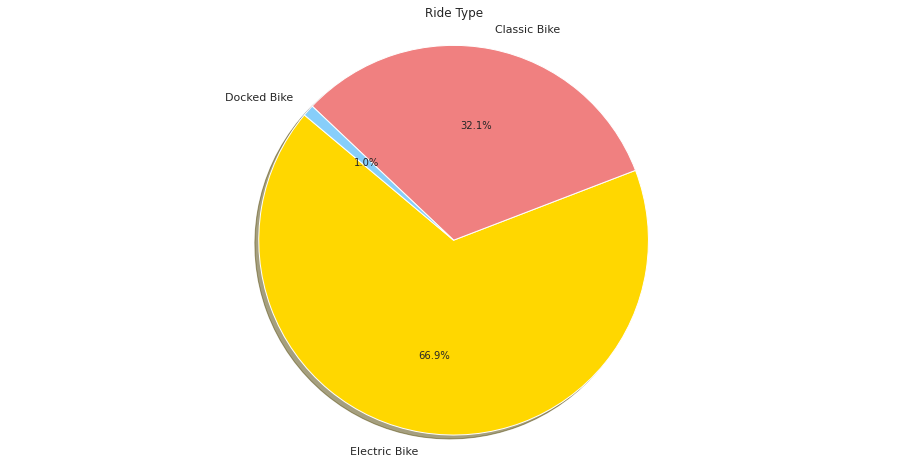

In [ ]:
plt.figure(figsize=(16,8))
labels = 'Electric Bike', 'Classic Bike', 'Docked Bike'
sizes = [138598, 66431, 1994]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Ride Type')
plt.axis('equal')
plt.show()

Clearly we can see, electric bike takes 67% market share and classic bike takes 32% market share. There are seldom people choose docked bike. 

## User Type

In [ ]:
#convert categorical data to numerica data
df_member_casual = pd.get_dummies(df, columns=['member_casual'])
member_casual = df_member_casual[['member_casual_member', 'member_casual_casual']]
member_casual = member_casual.rename(columns={'member_casual_member':'member', 'member_casual_casual':'casual'})
member_casual.value_counts()


member  casual
0       1         118702
1       0          83549
dtype: int64

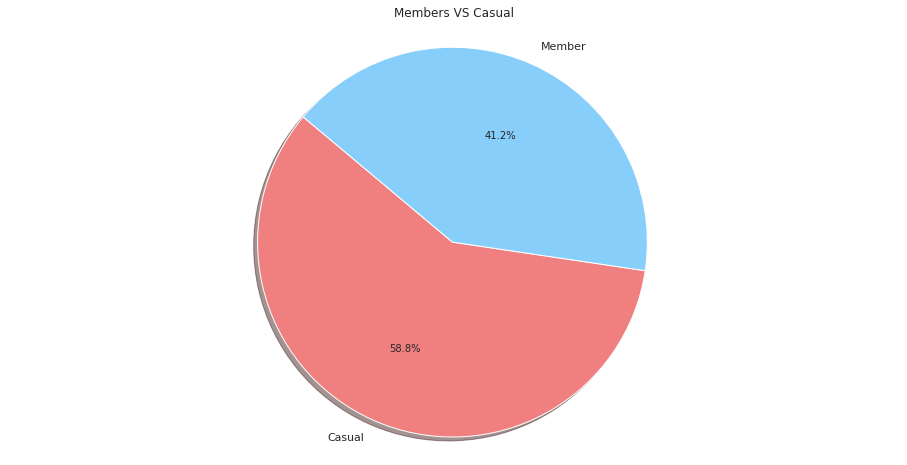

In [ ]:
plt.figure(figsize=(16,8))
labels = 'Casual', 'Member'
sizes = [121661,85362]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Members VS Casual')
plt.axis('equal')
plt.show()

Currently 59% are casual users and 41% are members. Then, we go futher step to have a look on users' preference on bike types

In [ ]:
user_type_bike_type= df[['rideable_type', 'member_casual']]
user_type_bike_type= pd.get_dummies(user_type_bike_type, columns=['rideable_type'])
user_type_bike_type=user_type_bike_type.groupby('member_casual').sum()
user_type_bike_type

,rideable_type_classic_bike,rideable_type_docked_bike,rideable_type_electric_bike
member_casual,,,
casual,34094.000,1809.000,82799.000
member,29787.000,0.000,53762.000


In [ ]:
#swap columns
user_type_bike_type_columns=['rideable_type_electric_bike','rideable_type_classic_bike', 'rideable_type_docked_bike']
user_type_bike_type=user_type_bike_type.reindex(columns=user_type_bike_type_columns)

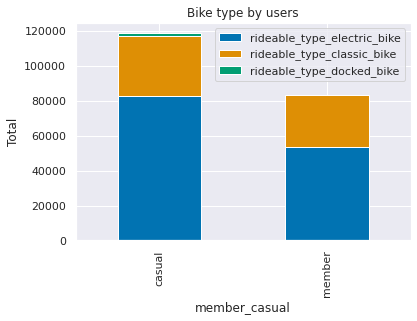

In [ ]:
import matplotlib.pyplot as plt


user_type_bike_type.plot.bar(stacked=True)

plt.ylabel('Total')
plt.title('Bike type by users')
plt.show()

In this chart, we can see no member uses docked bike. I believe this is because docked bike has to be returned back to a certain dock station, and both causual users and members prefer electric bikes.

## Average length of bike rides

In [ ]:
duration_mean = df['duration'].mean()
duration_mean 

Timedelta('0 days 00:14:31.075213472')

*Trip Duration by User Type*

Next, I want to know more about trip duration by each user type. I will use box plot to show the average trip duration by type of users and its variations.

In [ ]:
#convert timestamp data type to numeric
df['duration']=df['duration'].dt.total_seconds()/60

#find the average trip durationfor each type of user
means=df.groupby('member_casual')['duration'].mean()
means= means.to_frame().reset_index()


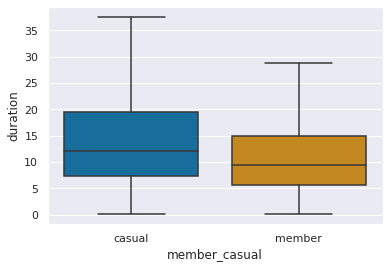

In [ ]:
sns.set(style="darkgrid", palette="colorblind")
sns.boxplot(x="member_casual",y="duration", data=df, showfliers=False, order=["casual","member"])

Since there are more casual users than members and they spend more time riding bikes, I recommend to target marketing strategies on casual members. 

To attract more people riding bike, Lyft can set more station near bart station, bus station and busy traffic intesections. Moreover, the company can set up some advertisement on the street or transportations to let more people know their products. Finally, the company can use pricing strategy, corporate collaborations and referral bonus to attract customers from their competitors. 

After increasing the number of casual users, the company could then look into converting them to members in order to further increase the total market share.


## Bike Usage

Next, I will look into daily and weekly bike usage 

### Variation of weekly count of users

In [ ]:
time_series= df[['started_at']]

In [ ]:
Duration = df[['started_at','ended_at', 'duration']]
#convert time stamp to day of week
day_of_week= Duration['started_at'].dt.day_name()
day_of_week=day_of_week.to_frame()
day_of_week.value_counts()

started_at
Tuesday       31602
Sunday        31420
Saturday      29926
Monday        28887
Friday        28548
Wednesday     26043
Thursday      25825
dtype: int64

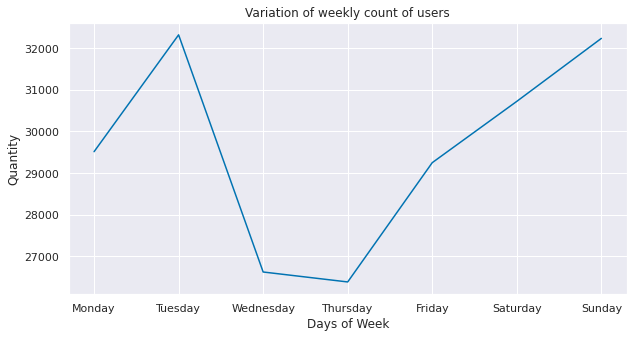

In [ ]:
#visualize the result
Day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Quantity = [29510, 32317, 26619, 26380, 29246, 30719,32232]
plt.figure(figsize=(10,5))
plt.plot(Day, Quantity)
plt.title('Variation of weekly count of users')
plt.xlabel('Days of Week')
plt.ylabel('Quantity')
plt.show()

The chart shows there are low usage on Wednesday and Thursday. Therefore, marketing team can provide some promotions on those days. 

### Number of bike rides on weekdays/weekends for registered vs. unregistered user

In [ ]:
#add a new column to show the day of week
weekdays_member_usage= df_member_casual[['started_at', 'member_casual_member', 'member_casual_casual']]
weekdays_member_usage= weekdays_member_usage.rename(columns={'member_casual_member':'member', 'member_casual_casual':'casual'})       
weekdays_member_usage['days_of_week'] = weekdays_member_usage['started_at'].dt.day_name()

#rename days of week to weekday and weekend
weekdays_member_usage.replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'weekday', inplace=True)   
weekdays_member_usage.replace(['Saturday', 'Sunday'], 'weekend', inplace=True)

#convert categorial data
weekdays_member_usage= pd.get_dummies(weekdays_member_usage, columns=['days_of_week'])     

#Group by type of users and count number of users during weekday
member_weekday =  weekdays_member_usage[['member', 'days_of_week_weekday']]
member_weekday_sort = member_weekday[member_weekday["days_of_week_weekday"] ==1]
member_weekday_sort=member_weekday.groupby(['member']).sum()
member_weekday_sort=member_weekday_sort.reset_index()
member_weekday_sort.days_of_week_weekday=member_weekday_sort['days_of_week_weekday'].astype(int)

#Group by type of users and count number of users during weekend
member_weekend_sort = member_weekday[member_weekday["days_of_week_weekday"] ==0]
member_weekend_sort=member_weekend_sort.groupby(['member']).count()
member_weekend_sort.rename(columns={'days_of_week_weekday':'days_of_week_weekend'}, inplace=True)
member_weekend_sort=member_weekend_sort.reset_index()      

#Show type of users during weekday and weekend
member_merge = member_weekday_sort.merge(member_weekend_sort, how='inner', on = 'member')
#member_merge=member_merge.rename(columns={'member_x':'member', 'member_y':'casual'})
member_merge.set_index('member', inplace=True)
member_merge  

,days_of_week_weekday,days_of_week_weekend
member,,
0,78039,40663
1,62866,20683


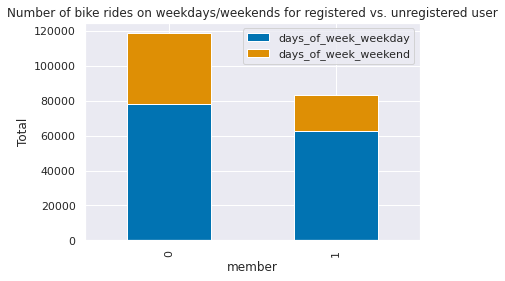

In [ ]:

member_merge.plot.bar(stacked=True)

plt.ylabel('Total')
plt.title('Number of bike rides on weekdays/weekends for registered vs. unregistered user')
plt.show()

Note: 0 as casual users and 1 as member users. 
This graph shows that weekend casual users have a higher percentage than weekend members. I believe this is due to increase in tourists over the weekend. 
On the other hand, member users during weekday usually has routine route to use their bike. Therefore, there are higher percentages of member users during weekday than casual users.

### Variation of hourly of users

In [ ]:
time_series['Hours'] = time_series['started_at'].dt.hour
time_series
#Hours = Hours.to_frame()
#Hours.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,started_at,Hours
0,2021-08-07 13:30:11,13
2,2021-08-31 18:28:04,18
3,2021-08-10 17:52:44,17
4,2021-08-11 18:01:21,18
5,2021-08-24 15:34:14,15
...,...,...
207018,2021-08-23 21:11:00,21
207019,2021-08-19 23:43:37,23
207020,2021-08-17 15:30:18,15
207021,2021-08-14 16:38:31,16


No handles with labels found to put in legend.


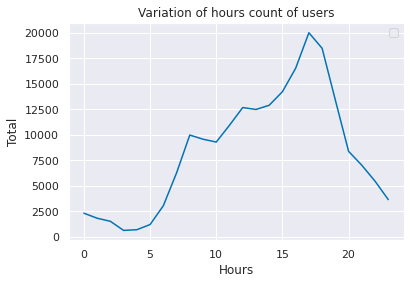

In [ ]:
#Groupby Hours
hours_various = time_series.groupby(['Hours']).count().sort_values(by='Hours', ascending = False)
hours_various_reset_index = hours_various.reset_index()

#Plot Variation of hours count of users
plt.plot(hours_various_reset_index['Hours'], hours_various_reset_index['started_at'], linestyle = '-')
plt.xlabel('Hours')
plt.ylabel('Total')
plt.title('Variation of hours count of users')
plt.legend()
plt.show()

This figure shows the bike using peak happends from 15pm to 19pm. People choose to ride a bike instead of other transportions to avoid the traffic. Therefore, Lyft could increase the price during the traffic time. I also created a heat map on Tableau to visualize the peak hours.

## Most popular bike stations

### Top 10 most popular station

In [ ]:
df_end_station_name = df[['end_station_name', 'ride_id']]
end_station_sort = df_end_station_name.groupby(['end_station_name']).count().sort_values(by='ride_id', ascending = False)
end_station_sort_reindex = end_station_sort.reset_index()
#start_station_counts= df_start_station_name.value_counts().head()
Top_10_end_station=end_station_sort_reindex.head(10)
Top_10_end_station

,end_station_name,ride_id
0,Market St at 10th St,2353
1,Powell St BART Station (Market St at 4th St),2052
2,Powell St BART Station (Market St at 5th St),1669
3,Market St at Steuart St,1634
4,17th St at Valencia St,1533
5,San Francisco Caltrain (Townsend St at 4th St),1525
6,Mission Dolores Park,1422
7,Berry St at 4th St,1412
8,4th St at Mission Bay Blvd S,1376
9,Sanchez St at 15th St,1375


### Least 10 popular station

In [ ]:
df_end_station_name = df[['end_station_name', 'ride_id']]
end_station_sort = df_end_station_name.groupby(['end_station_name']).count().sort_values(by='ride_id', ascending = False)
end_station_sort_reindex = end_station_sort.reset_index()
#start_station_counts= df_start_station_name.value_counts().head()
Bot_10_end_station=end_station_sort_reindex.tail(10)
Bot_10_end_station

,end_station_name,ride_id
455,Oak St at 1st St,8
456,Lane St at Revere Ave,6
457,Lab - Howard,6
458,23rd Ave at Foothill Blvd,6
459,Farnam St at Fruitvale Ave,5
460,Bird Ave at Coe Ave,5
461,1st St at Younger Ave,5
462,Bond St at High St,4
463,Foothill Blvd at Fruitvale Ave,4
464,Foothill Blvd at Harrington Ave,2


As Tableau can create interactive visualization, I created a tableau dashboard to display the important information in my analysis. It includes a density map to show most and least popular stations, a location map to show bike station locations (user can toggle between the two maps), a heat map to show peak rental by hours and weekdays, and finally a bar chart to display type of bikes preferred by users.
https://public.tableau.com/app/profile/yichen.li1642/viz/BayWheelAnalysis/BayWheelAnalysis

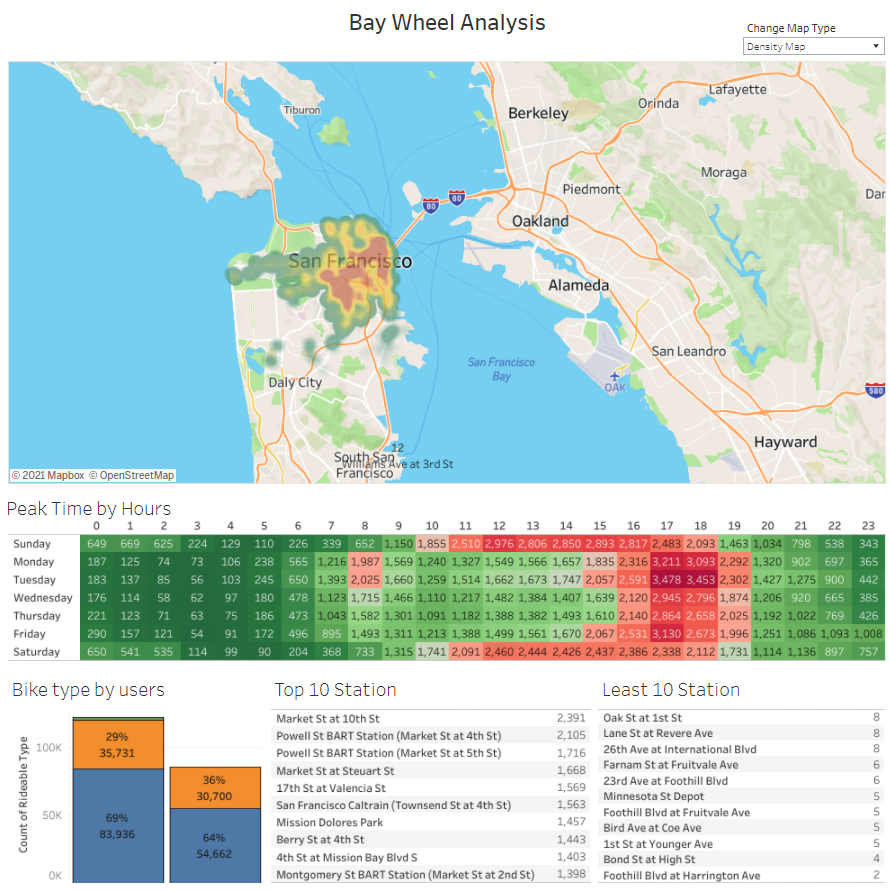

# Conclusion

Through my analysis, I found that 67% are casual users and 32% are members. Nevertheless, both type of users prefer electric bike and their average bike rental time for is around 15 minute. The most popular rental days are the weekend and least popular days are Wednesday and Thursday. It is interesting to note that afternoon traffic hour has higher rental rates than morning traffic hours for weekdays and most popular hours for bike rental is between 4pm to 6pm. The density map shows top 10 popular bike station are in San Francisco whereas least 10 popular stations are mostly in East Bay. Overall Bay Wheel Analysis has been an interesting project. There are many different type of information in the data which calls for different type of visualization. Through Python and Tableau, I had fun exploring the data, looking into potential causes for data disparity and interpreting the analysis.

# Recommendation



1.   Fix electric bike system storage error on latitude and longitude, so more decimal places are stored.
    
2.   Enhance bike return process and alert users when the bike isn't returned successfully.

3.   Increase number of electric bike.

4.  Attract more non-member riding bike. 

    4.1.   Setup more bike rentals near bart stations, bus stations and busy traffic intesections

    4.2.   Increase advertisement on the street or visable locations to increase bike rental awareness

    4.3.    Use pricing strategies to attract customers from competitors

5.   Convert casual customers to members

    5.1.   corporate collaborations 

    5.2.   referral bonus

6.    Provide promotions and incentives on least popular days (Wednesday and Thursday) to increase revenue.

7.   Increase bike rental price during traffic hours




# Future Analysis

Currently only ride_id is given but if user_id can be provided, then I can investigate more into type of users. For example are the 67% causal users repeat users or single time users. This can give insight to whether they are SF residents or tourist. Are the 32% members consists few members but rides a lot or many members but don’t ride many trips. These information allows us to have a better sense of current market and come up with corresponding marketing strategies.

Current dataset is only for August 2021. If more data can be given such as a year's data, I can perform seasonality analysis.

If weather data can be collected, then I can check for correlations and better predict demand.

If user gender, age, and historical avg riding speed, and weather data are available I can build model to predict personalized trip durations that may not have historical records.


